# Picky: LLM/RAG-based Movie Recommendation System 
## Overview

Picky project is a movie recommendation system that involves three distinct recommendation techniques to provide a holistic and personalized user experience.

Recommender systems are algorithms designed to suggest products, content, or services to users based on their preferences and behaviors. They analyze data such as past interactions, ratings, and user profiles to predict what users might like. Common techniques include collaborative filtering, which leverages similarities between users or items, and content-based filtering, which recommends items similar to those a user has liked based on item features. Recommender systems are widely used in various domains, including e-commerce, streaming services, and social media, to enhance user experience and engagement. 

In this project, we will explore various approaches to build a movie recommendation system:

1. **Collaborative Filtering**: This approach recommends movies based on user interactions and preferences. By analyzing patterns and similarities between users, Picky identifies movies enjoyed by others with similar tastes, making personalized suggestions based on collective user behavior.

2. **Content-Based Recommendation**: Picky also provides content-based recommendations, which focuses on the attributes of movies. It analyzes features such as genre and tags to suggest movies that align with the user's specific interests and preferences.

3. **RAG (Retrieval-Augmented Generation)**: Combining document retrieval from a vectorstore and large language models, RAG enhances Picky’s recommendations by fetching relevant information from a database and generating context-aware suggestions. This allows the system to provide recommendations that are both contextually relevant and tailored to user queries.

**Potential Use Cases for a Movie Recommender Systems**

- **Personalized Movie Recommendations**: Enhance user experience by suggesting movies tailored to individual preferences.

- **Movie Discovery and Engagement**: Help users discover new and relevant movies based on their viewing history and interests.

- **Targeted Advertising and Marketing for Movies**: Increase the effectiveness of marketing campaigns by promoting movies that align with user preferences.

- **Dynamic Movie Search Results**: Improve search result relevance by customizing movie search results according to user behavior and tastes.

- **Enhanced User Retention and Loyalty in Movie Platforms**: Improve user retention and build loyalty by offering personalized movie recommendations and viewing experiences.

*These use cases can also be adapted for recommender systems across various domains and purposes.*

In [ ]:
# Install required packages for this project
# !pip install -qU numpy pandas python-dotenv lightfm langchain langchain-openai langchain-community openai pinecone-client tiktoken

In [ ]:
# Imports for System Environment and Utilities
import os
from collections import Counter
from dotenv import load_dotenv
import pickle
from tqdm.auto import tqdm
from uuid import uuid4
import time

# Imports for Data Manipulation and Processing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix

# Imports for Recommender Systems
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.cross_validation import random_train_test_split


# Imports for Text Processing and Similarity Measures
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tiktoken

# Imports for Vector Search and Database Management
import pinecone
from pinecone import Pinecone, ServerlessSpec

# Imports for Language Model Integration
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.vectorstores import Pinecone
from langchain.chains import RetrievalQA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


## Dataset
For this project, we will use the MovieLens 32M dataset, which can be accessed [here](https://grouplens.org/datasets/movielens/). 

The MovieLens 32M dataset is a substantial collection of movie ratings and metadata, featuring 32 million ratings and two million tag applications. It includes detailed information about 87,585 movies and 200,948 users. Collected in October 2023 and released in May 2024, it is widely used for building and evaluating recommender systems.

In [35]:
# download and unzip movielens data
# !wget http://files.grouplens.org/datasets/movielens/ml-32m.zip
# !unzip ml-32m.zip

First, we'll explore the various components of the dataset. It consists of separate CSV files for movies, ratings, tags, and associated links, which can be combined using the `movieId`. The dataset does not include any demographic information. Each user is represented solely by an `id`, with no additional details provided.


The data is organized into four files:


- **movie.csv**: Contains information about movies:
  - `movieId`: Identifier for the movie.
  - `title`: Title of the movie.
  - `genres`: Genres associated with the movie.

- **rating.csv**: Contains ratings of movies by users:
  - `userId`: Identifier for the user who rated the movie.
  - `movieId`: Identifier for the rated movie.
  - `rating`: The rating given to the movie.
  - `timestamp`: The time when the rating was given.

- **tag.csv**: Contains tags applied to movies by users:
  - `userId`: Identifier for the user who applied the tag.
  - `movieId`: Identifier for the movie that was tagged.
  - `tag`: The text of the tag applied to the movie.
  - `timestamp`: The time when the tag was applied.

- **link.csv**: Contains identifiers for linking to external sources:
  - `movieId`: Identifier for the movie.
  - `imdbId`: IMDb identifier for the movie.
  - `tmdbId`: TMDb identifier for the movie.

### Movies

The movies data includes the title (name and year) and a list of genres. We'll further process this data to separate the name and year and convert the genres into a list.

In [ ]:
movies_src = pd.read_csv('ml-32m/movies.csv')
movies_src.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies = movies_src.copy()

# rename columns
movies.rename(columns={'title': 'title_year'}, inplace=True)

# Split 'title_year' into 'title' and 'year'
movies[['title', 'year']] = movies['title_year'].str.extract(r'^(.*)\s\((\d{4})\)$')
movies.drop(columns=['title_year'], inplace=True)
# Convert 'year' to integers
movies['year'] = movies['year'].fillna(-1).astype(int)

# split genres string into a list
movies['genres'] = movies['genres'].str.split('|')
movies['genres'] = movies['genres'].apply(lambda x: [genre.lower().replace(' ', '_') for genre in x])

movies.head()


,movieId,genres,title,year
0,1,"[adventure, animation, children, comedy, fantasy]",Toy Story,1995
1,2,"[adventure, children, fantasy]",Jumanji,1995
2,3,"[comedy, romance]",Grumpier Old Men,1995
3,4,"[comedy, drama, romance]",Waiting to Exhale,1995
4,5,[comedy],Father of the Bride Part II,1995


#### Genre & Release Year
Let's analyze the distribution of movies per year and their genres in the dataset. Most movies are classified under the drama genre, and the distribution is skewed toward more recent years, as anticipated.

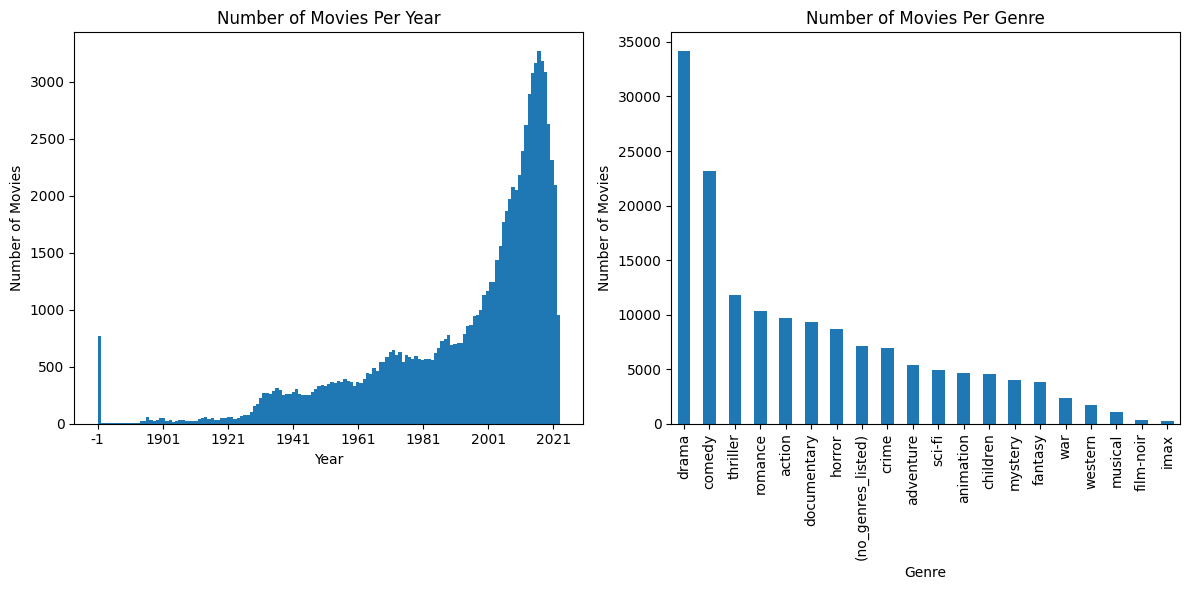

In [ ]:
# Count the number of movies per year
movies_per_year = movies['year'].value_counts().sort_index()

# Count the number of movies per genre
genre_counter = Counter()
for genres in movies['genres']:
    genre_counter.update(genres)

movies_per_genre = pd.Series(genre_counter).sort_values(ascending=False)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Number of movies per year subplot
axs[0].hist(movies_per_year.index.astype(str), bins=len(movies_per_year), weights=movies_per_year.values)
axs[0].set_title('Number of Movies Per Year')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Number of Movies')
# Show labels for every 10 bins
xticks = range(0, len(movies_per_year), 20)
axs[0].set_xticks(xticks)


# Number of movies per genre subplot
movies_per_genre.plot(kind='bar', ax=axs[1])
axs[1].set_title('Number of Movies Per Genre')
axs[1].set_xlabel('Genre')
axs[1].set_ylabel('Number of Movies')

plt.tight_layout()
plt.show()


In [ ]:
# Helper function to retrieve a movie_id based on the movie title

def get_movie_id(title):
    """
    Gets the movie ID for a given title. If multiple movies with the same title exist,
    returns the ID of the most recent one.

    Args:
        title: The title of the movie.
    Returns:
        he movie ID or None if the movie is not found.
    """
    matching_movies = movies[movies['title'].str.lower() == title.lower()]
    if matching_movies.empty:
        return None
    else:
        # Sort by year in descending order and return the ID of the first (most recent) movie
        most_recent_movie = matching_movies.sort_values('year', ascending=False).iloc[0]
        return int(most_recent_movie['movieId'])

get_movie_id('Fight Club')

2959

#### Links (IMDB ID)
Our dataset also includes Links.csv which provides IMDb and TMDB IDs for each movie. We’ll use the IMDb ID later to retrieve movie descriptions.

In [ ]:
# Load links dataset
links = pd.read_csv('ml-32m/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


### Ratings
Let's analyze the distribution of the number of movies rated by users and the number of ratings each movie has received. 


In [ ]:
# Load ratings dataset
ratings = pd.read_csv('ml-32m/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858



As expected, most users have rated only a small number of movies, and most movies have received relatively few ratings. However, userID = 175325 stands out with over 33,000 movies rated!

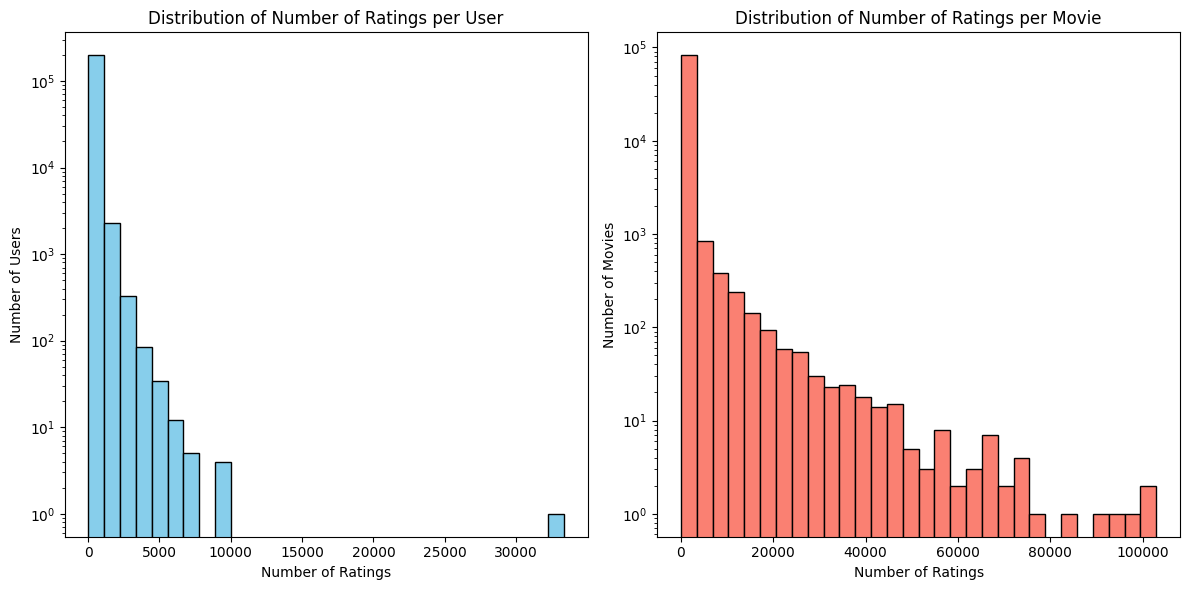

In [ ]:
# Plot 1: Distribution of number of ratings per user and per movie
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Distribution of number of ratings per user
user_rating_counts = ratings['userId'].value_counts()
axs[0].hist(user_rating_counts, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Number of Ratings per User')
axs[0].set_xlabel('Number of Ratings')
axs[0].set_ylabel('Number of Users')
axs[0].set_yscale('log')  # Use log scale for y-axis

# Distribution of number of ratings per movie
movie_rating_counts = ratings['movieId'].value_counts()
axs[1].hist(movie_rating_counts, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Distribution of Number of Ratings per Movie')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Number of Movies')
axs[1].set_yscale('log')  # Use log scale for y-axis

plt.tight_layout()
plt.show()

#### Average rating
We can join the movies table with the ratings table to obtain the number of ratings and the average rating for each movie.

In [ ]:
# Calculate average rating and count of ratings
rating_stats = ratings.groupby('movieId')['rating'].agg(['mean', 'count']).reset_index()

# Rename columns for clarity
rating_stats.rename(columns={'mean': 'rating_average', 'count': 'rating_count'}, inplace=True)

# Merge the calculated statistics with the movies DataFrame
movies = pd.merge(movies, rating_stats, on='movieId')

# Display the result
movies.head()

,movieId,genres,title,year,rating_average,rating_count
0,1,"[adventure, animation, children, comedy, fantasy]",Toy Story,1995,3.897438,68997
1,2,"[adventure, children, fantasy]",Jumanji,1995,3.275758,28904
2,3,"[comedy, romance]",Grumpier Old Men,1995,3.139447,13134
3,4,"[comedy, drama, romance]",Waiting to Exhale,1995,2.845331,2806
4,5,[comedy],Father of the Bride Part II,1995,3.059602,13154


Next, let’s examine the distribution of all the ratings, user average ratings, and movie average ratings.

It appears that overall ratings are slightly skewed towards higher values. User average ratings are centered around ~4, while movie average ratings are centered around ~3.

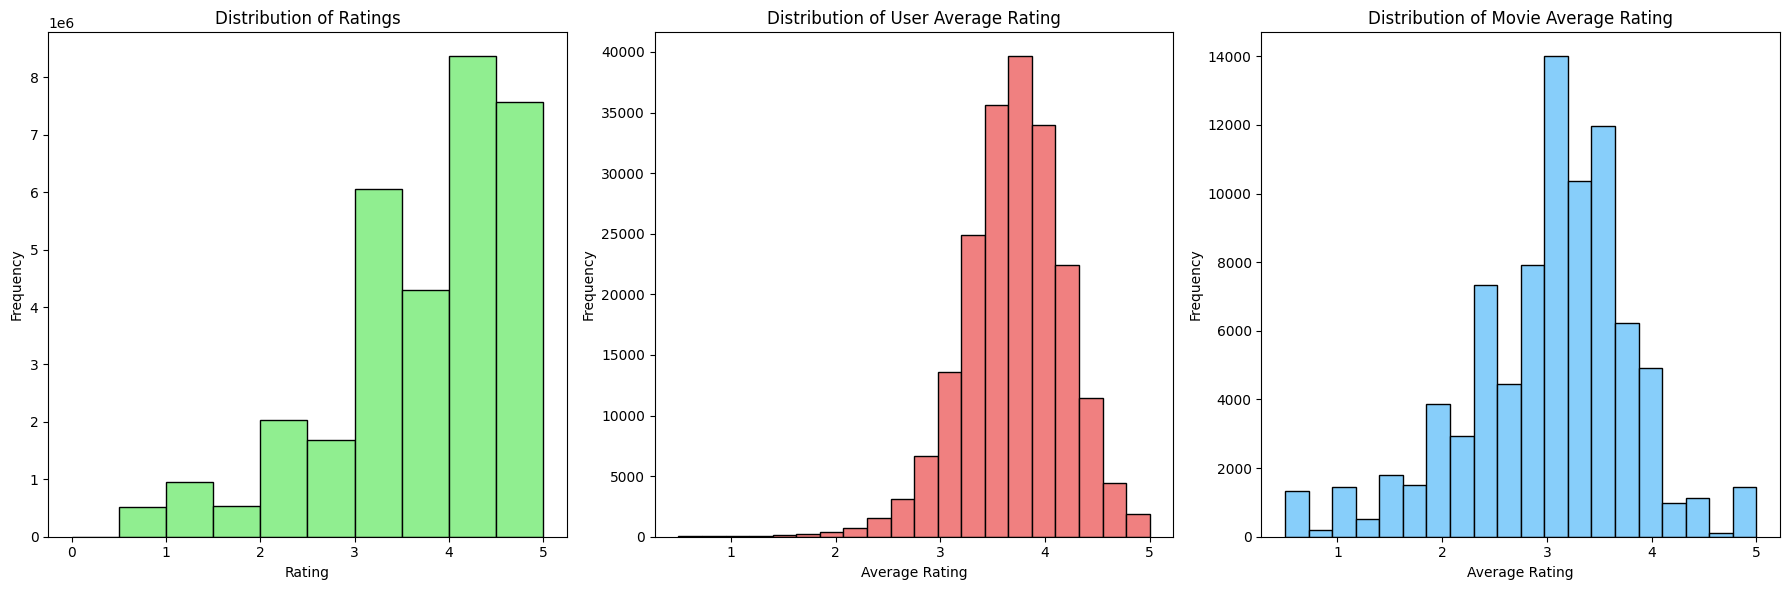

In [ ]:
# Plot 2: Distribution of ratings, user average rating, and movie average rating
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Distribution of ratings
axs[0].hist(ratings['rating'], bins=[i * 0.5 for i in range(11)], color='lightgreen', edgecolor='black')
axs[0].set_title('Distribution of Ratings')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Frequency')

# Distribution of user average rating
user_avg_rating = ratings.groupby('userId')['rating'].mean()
axs[1].hist(user_avg_rating, bins=20, color='lightcoral', edgecolor='black')
axs[1].set_title('Distribution of User Average Rating')
axs[1].set_xlabel('Average Rating')
axs[1].set_ylabel('Frequency')

# Distribution of movie average rating
movie_avg_rating = ratings.groupby('movieId')['rating'].mean()
axs[2].hist(movie_avg_rating, bins=20, color='lightskyblue', edgecolor='black')
axs[2].set_title('Distribution of Movie Average Rating')
axs[2].set_xlabel('Average Rating')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Weighted rating

A movie's high or low average rating, when based on a small number of votes, may not accurately reflect its true quality. To address this issue, we calculate a weighted rating that considers both the movie’s average rating and the number of ratings it has received.

This method combines the movie's average rating with the overall average rating, adjusting based on the number of ratings. Movies with a high number of ratings will have their average rating weighted more heavily, while those with fewer ratings will rely more on the overall average rating. This approach provides a more balanced ranking of movies by integrating both the number of ratings and the average rating.


The weighted rating, referred to as the movie score, is computed using the following formula:

$$ \text{Score} = \left(\frac{v}{v + m} \times R\right) + \left(\frac{m}{m + v} \times C\right)$$
where:
- `v` is the number of ratings for the movie,
- `R` is the movie's average rating,
- `m` is the minimum number of ratings required to be considered in the calculation (e.g., the 90th percentile of the rating counts),
- `C` is the overall average rating across all movies.



Now, we can examine the top 10 movies of all time with the highest scores to determine if they indicate high-quality films.



In [ ]:
C = movies['rating_average'].mean()
m = movies['rating_count'].quantile(0.90)

def weighted_rating(x, m=m, C=C):
    v = x['rating_count']
    R = x['rating_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movies['score'] = movies.apply(weighted_rating, axis=1)
movies.sort_values('score', ascending=False, inplace=True)
movies.head(10)

,movieId,genres,title,year,rating_average,rating_count,score
314,318,"[crime, drama]","Shawshank Redemption, The",1994,4.404614,102929,4.401238
39306,159817,[documentary],Planet Earth,2006,4.444369,2948,4.332311
840,858,"[crime, drama]","Godfather, The",1972,4.317030,66440,4.312134
44042,170705,"[action, drama, war]",Band of Brothers,2001,4.426539,2811,4.310914
58698,202439,"[comedy, drama]",Parasite,2019,4.312254,11670,4.284956
44190,171011,[documentary],Planet Earth II,2016,4.446830,1956,4.284079
49,50,"[crime, mystery, thriller]","Usual Suspects, The",1995,4.265070,67750,4.260458
1190,1221,"[crime, drama]","Godfather: Part II, The",1974,4.264468,43111,4.257239
1173,1203,[drama],12 Angry Men,1957,4.265311,21863,4.251126
522,527,"[drama, war]",Schindler's List,1993,4.236990,73849,4.232852


We'll create a function to filter movies based on criteria such as release year, genre, and rating. This will allow us to select movies according to a user's specific requirements. Additionally, we'll use this function to choose the top 1000 movies for training our recommendation system.

In [ ]:
def filter_movies(movies, min_year=2000, max_year=2024, min_score=4.0, min_rating_average=4.0, min_rating_count=10000, genres=None, sort_by='score', top=10):
    """
    Filters movies based on given criteria.

    Args:
        movies: DataFrame of movies.
        min_year: Minimum year of release (inclusive).
        max_year: Maximum year of release (inclusive).
        min_score: Minimum score.
        min_rating_average: Minimum average rating.
        min_rating_count: Minimum number of ratings required.
        genres: List of genres to include.
        sort_by: Column to sort by.
        top_k: Number of top movies to return.

    Returns:
        Filtered DataFrame of movies.
    """
    filtered_movies = movies.copy()

    # Filter by year
    if min_year:
        filtered_movies = filtered_movies[filtered_movies['year'] >= min_year]
    if max_year:
        filtered_movies = filtered_movies[filtered_movies['year'] <= max_year]

    # Filter by score
    if min_score:
        filtered_movies = filtered_movies[filtered_movies['score'] >= min_score]

    # Filter by average rating and rating count
    if min_rating_average:
        filtered_movies = filtered_movies[filtered_movies['rating_average'] >= min_rating_average]
    if min_rating_count:
        filtered_movies = filtered_movies[filtered_movies['rating_count'] >= min_rating_count]

    # Filter by genres
    if genres:
        filtered_movies = filtered_movies[filtered_movies['genres'].apply(lambda x: any(genre.lower() in x for genre in genres))]

    # Sort the DataFrame
    if sort_by:
        filtered_movies.sort_values(sort_by, ascending=False, inplace=True)

    # Return the top K movies
    return filtered_movies.head(top)


### High-rated movies 
As an example, here are the top 10 movies released after 1970, with a minimum score of 4 and at least 10,000 ratings, in the drama genre, sorted by score:

In [76]:
high_rated_movies = filter_movies(movies, min_year=1970, max_year=2024, 
                                  min_score=4.0, min_rating_average=4.0, min_rating_count=10000, 
                                  genres=['drama'], sort_by='score', top=10)
high_rated_movies

,movieId,genres,title,year,rating_average,rating_count,score
314,318,"[crime, drama]","Shawshank Redemption, The",1994,4.404614,102929,4.401238
840,858,"[crime, drama]","Godfather, The",1972,4.317030,66440,4.312134
58698,202439,"[comedy, drama]",Parasite,2019,4.312254,11670,4.284956
1190,1221,"[crime, drama]","Godfather: Part II, The",1974,4.264468,43111,4.257239
522,527,"[drama, war]",Schindler's List,1993,4.236990,73849,4.232852
2867,2959,"[action, crime, drama, thriller]",Fight Club,1999,4.228780,77332,4.224854
1164,1193,[drama],One Flew Over the Cuckoo's Nest,1975,4.204229,44592,4.197573
292,296,"[comedy, crime, drama, thriller]",Pulp Fiction,1994,4.196969,98409,4.193962
1182,1213,"[crime, drama]",Goodfellas,1990,4.188427,42003,4.181456
10704,44555,"[drama, romance, thriller]","Lives of Others, The (Das leben der Anderen)",2006,4.198770,12273,4.175043


Before training the models, we will first select a subset of our dataset, focusing on the top 1,000 movies with the highest scores released after 1970.

In [77]:
filtered_movies = filter_movies(movies, min_year=1970, max_year=2024, min_score=3.0, min_rating_average=3.0, min_rating_count=1000, genres=None, sort_by='score', top=1000)
filtered_movies

,movieId,genres,title,year,rating_average,rating_count,score
314,318,"[crime, drama]","Shawshank Redemption, The",1994,4.404614,102929,4.401238
39306,159817,[documentary],Planet Earth,2006,4.444369,2948,4.332311
840,858,"[crime, drama]","Godfather, The",1972,4.317030,66440,4.312134
44042,170705,"[action, drama, war]",Band of Brothers,2001,4.426539,2811,4.310914
58698,202439,"[comedy, drama]",Parasite,2019,4.312254,11670,4.284956
...,...,...,...,...,...,...,...
52160,188189,"[comedy, fantasy, sci-fi]",Sorry to Bother You,2018,3.732790,2455,3.665803
1026,1050,"[documentary, drama]",Looking for Richard,1996,3.758183,1772,3.665429
7546,7934,[comedy],Zelig,1983,3.766075,1633,3.665426
11153,48696,"[drama, romance]",Little Children,2006,3.746180,2029,3.665203


## Collaborative filtering recommendation system
Collaborative filtering is a recommendation technique that predicts a user's preferences based on the preferences of similar users. It operates on the principle that if two users have similar tastes in the past, they are likely to have similar tastes in the future. This method leverages user-item interaction data, such as ratings or clicks, to identify patterns and make recommendations. Collaborative filtering can be user-based, focusing on finding users with similar preferences, or item-based, focusing on finding items similar to those a user has liked. This approach relies on the collective input of the user community to generate personalized recommendations.

An interaction matrix represents user preferences for items (e.g., movies) by showing which users rated which items and how. Here's how it works:

1. **Filter Data**: Select user ratings only for the movies in your subset.
2. **Create Matrix**: Use a pivot table to organize ratings with users as rows and movies as columns. Missing ratings are filled with `0`.
3. **Matrix Shape**: `interaction_matrix.shape` gives the dimensions of the matrix, showing the number of users and movies.

In [78]:
# Filter user_ratings to include only movies present in filtered_movies
filtered_movie_ids = filtered_movies['movieId'].tolist()
filtered_user_ratings = ratings[ratings['movieId'].isin(filtered_movie_ids)]

# Create an interaction matrix
interaction_matrix = filtered_user_ratings.pivot(index='userId', columns='movieId', values='rating').fillna(0)
interaction_matrix.shape

(200774, 1000)

As observed, the matrix is mostly filled with zeros (sparse matrix) because most users have not rated the majority of movies.

In [36]:
interaction_matrix.head(5)

movieId,1,6,16,17,25,28,29,32,36,41,...,250010,254726,263007,270698,274053,278446,278578,281096,286897,287699
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,1.0,0.0,2.0,5.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LightFM
LightFM is a hybrid recommendation algorithm that blends collaborative and content-based filtering using matrix factorization to enhance recommendations.

**WARP**: (Weighted Approximate-Rank Pairwise) loss is commonly used for implicit feedback scenarios, where the goal is to optimize the ranking of positive items over negative items.

Here is how WARP works:

- Finding Mistakes: Imagine you have a list of favorite movies and some movies you don’t like. For each favorite movie, WARP tries to find a movie you don’t like that’s mistakenly ranked higher on the list.
- Measuring Mistakes: It checks how wrong the list is when a disliked movie is ranked higher than your favorite.
- Focusing on Big Mistakes: It pays more attention to big mistakes where the disliked movie is much higher up on the list, trying to fix those first.


LightFM requires a sparse interaction matrix as input, fits a model to it, and can then predict ratings for any user/movie pair.

In [37]:
# Convert the interaction matrix to the format required by LightFM
interaction_matrix_sparse = coo_matrix(interaction_matrix.values)

# Split the data into training and testing sets
train, test = random_train_test_split(interaction_matrix_sparse, test_percentage=0.2)

# Initialize and fit the LightFM model
model_collaborative = LightFM(loss='warp')  # You can experiment with different loss functions
model_collaborative.fit(train, epochs=10, num_threads=4, verbose=True)


Epoch: 100%|██████████| 10/10 [03:07<00:00, 18.71s/it]


It's a good practice to save the model to avoid retraining. You can use `pickle` to serialize and store the model.

In [38]:
# Save the model
filename = 'model_collaborative.sav'
pickle.dump(model_collaborative, open(filename, 'wb'))


### Evaluation

**Precision@k** measures how many of the top-k recommended items are relevant. It calculates the proportion of relevant items among the top-k recommendations. For instance, if 3 out of 5 recommended movies are relevant, precision@5 is 60%.

The test precision is much lower than the training precision, indicating underfitting and suggesting that more training epochs could improve the model.

In [39]:
# Evaluate the model
train_precision = precision_at_k(model_collaborative, train, k=10).mean()
test_precision = precision_at_k(model_collaborative, test, k=10).mean()

print(f"Train precision: {train_precision}")
print(f"Test precision: {test_precision}")

Train precision: 0.5388532280921936
Test precision: 0.11510593444108963


### Collaborative recommendations
We'll create two helper functions:

- **`get_top_rated_movies_for_user`**: Returns the top-rated movies by a given user, merged with movie information.
- **`predict_ratings_for_user`**: Predicts ratings for all unseen movies for a given user and returns the top-rated unseen movies.



In [40]:
def get_top_rated_movies_for_user(user_id, ratings=filtered_user_ratings, movies=filtered_movies, top=5):
    """
    Returns the top N rated movies by a given user, merged with movie information.

    Args:
        user_id: The ID of the user.
        ratings: The DataFrame containing user ratings.
        movies: The DataFrame containing movie information.
        top_n: The number of top movies to return.

    Returns:
      A DataFrame containing the top N rated movies by the user, including movie information.
    """
    # Check if the user ID is valid
    if user_id not in ratings['userId'].unique():
      raise ValueError(f"User ID {user_id} not found in the ratings DataFrame.")

    # Filter ratings for the given user
    user_ratings = ratings[ratings['userId'] == user_id]

    # Merge the top movies with the user's ratings to include the ratings
    user_ratings_merged = pd.merge(user_ratings, movies, on='movieId')

    # Sort the merged DataFrame by rating in descending order
    user_ratings_sorted = user_ratings_merged.sort_values(by=['rating', 'score'], ascending=False)

    return user_ratings_sorted.head(top)

In [41]:
def predict_ratings_for_user(user_id, model=model_collaborative, interaction_matrix=interaction_matrix, top=5):
    """
    Predicts ratings for all unseen movies for a given user.

    Args:
        user_id: The ID of the user.
        model: The trained LightFM model.
        interaction_matrix: The interaction matrix.
        top_n: The number of top recommendations to return.

    Returns:
        A DataFrame with the predicted ratings for unseen movies, sorted in descending order.
    """
    # Check if the user ID is valid
    if user_id not in interaction_matrix.index:
        raise ValueError(f"User ID {user_id} not found in the interaction matrix.")

    # Get the number of movies
    num_movies = interaction_matrix.shape[1]

    # Predict ratings for all movies for the user
    predicted_ratings = model.predict(user_ids=user_id, item_ids=np.arange(num_movies))

    # Get the movies the user has already rated
    known_positives = interaction_matrix.loc[user_id, :][interaction_matrix.loc[user_id, :] > 0].index.tolist()

    # Create a DataFrame for the predictions
    predictions_df = pd.DataFrame({
        'movieId': interaction_matrix.columns,
        'predicted_rating': predicted_ratings
    })

    # Remove movies the user has already rated
    predictions_df = predictions_df[~predictions_df['movieId'].isin(known_positives)]

    # Sort the predictions in descending order
    predictions_df.sort_values('predicted_rating', ascending=False, inplace=True)

    # Merge with movie titles and year
    predictions_df = pd.merge(predictions_df, filtered_movies[['movieId', 'title', 'year']], on='movieId', how='left')

    # Return the top N predictions
    return predictions_df.head(top)

We'll examine the movies that userID = 8 has rated highly, as well as the movies that our model recommends to this user.

In [42]:
user_id = 8  # Example user ID

user_rated_movies = get_top_rated_movies_for_user(user_id)
user_rated_movies

,userId,movieId,rating,timestamp,genres,title,year,rating_average,rating_count,score
12,8,2959,5.0,1553765392,"[action, crime, drama, thriller]",Fight Club,1999,4.228780,77332,4.224854
5,8,593,5.0,1553765397,"[crime, horror, thriller]","Silence of the Lambs, The",1991,4.148367,90330,4.145225
6,8,608,5.0,1553765495,"[comedy, crime, drama, thriller]",Fargo,1996,4.116533,58031,4.111786
1,8,47,5.0,1553765552,"[mystery, thriller]",Seven (a.k.a. Se7en),1995,4.087199,63298,4.082960
20,8,27773,5.0,1553767405,"[mystery, thriller]",Old Boy,2003,4.089464,17331,4.074111


In [43]:
recommended_movies_collaborative = predict_ratings_for_user(user_id)
recommended_movies_collaborative

,movieId,predicted_rating,title,year
0,1089,2.635214,Reservoir Dogs,1992
1,2997,2.087071,Being John Malkovich,1999
2,2542,2.062857,"Lock, Stock & Two Smoking Barrels",1998
3,50,1.941176,"Usual Suspects, The",1995
4,2571,1.872414,"Matrix, The",1999


## Content-based recommendation system
A content-based recommendation system suggests items by analyzing their features and matching them with a user's past preferences. It recommends similar items based on the content attributes of items the user has liked, rather than relying on other users' behaviors. This method is useful for providing relevant suggestions, especially for new or specific items.

### Tags
To build our content-based model, we'll use the tags dataset, which includes the tags that users have assigned to movies.

In [72]:
# Load tags dataset
tags = pd.read_csv('ml-32m/tags.csv')
tags['tag'] = tags['tag'].str.lower().str.replace(' ', '_').astype(str)
tags.head()

,userId,movieId,tag,timestamp
0,22,26479,kevin_kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


To better identify the most important tags for each movie, we'll count how often each tag is assigned to a movie. We'll use the `cyclic_join` helper function to combine the tags for each movie, ordered by their frequency.

In [73]:
def cyclic_join(tags_list):
    """
    Process a list of tags by counting their frequencies and creating a cyclically ordered string.

    Args:
        tags_list (list): A list of tags to be processed.

    Returns:
        str: A space-separated string of tags, ordered by frequency in descending order,
              with more frequent tags appearing first and arranged cyclically.
    """
    # Count tag frequencies
    tag_count = Counter(tags_list)

    # Create a list of tags sorted by frequency in descending order
    sorted_tags = [tag for tag, _ in tag_count.most_common()]

    # Create a result list and fill it cyclically
    result = []
    while sum(tag_count.values())>0:
        for tag in sorted_tags:
            if tag_count[tag] > 0:
                result.append(tag)
                tag_count[tag] -= 1

    # Join tags into a single string
    return ' '.join(result)

# Example
tags_list = ['action', 'adventure', 'thriller', 'comedy', 'action', 'thriller', 'action']
print(cyclic_join(tags_list))  # Output will be the tags in cyclic order by frequency


action thriller adventure comedy action thriller action


We can now group the tags by movie and add them as a column to our movies DataFrame.

In [79]:
# Group tags by movie into lists
tags_filtered = tags[tags['movieId'].isin(filtered_movie_ids)]
tags_grouped = tags_filtered.groupby('movieId')['tag'].apply(cyclic_join).reset_index()
tags_grouped.head()

,movieId,tag
0,1,pixar animation disney funny tom_hanks compute...
1,6,al_pacino robert_de_niro great_acting realisti...
2,16,martin_scorsese mafia robert_de_niro organized...
3,17,jane_austen british romantic alan_rickman hugh...
4,25,depressing alcoholism nicolas_cage melancholic...


Let's visualize the most frequent tags.

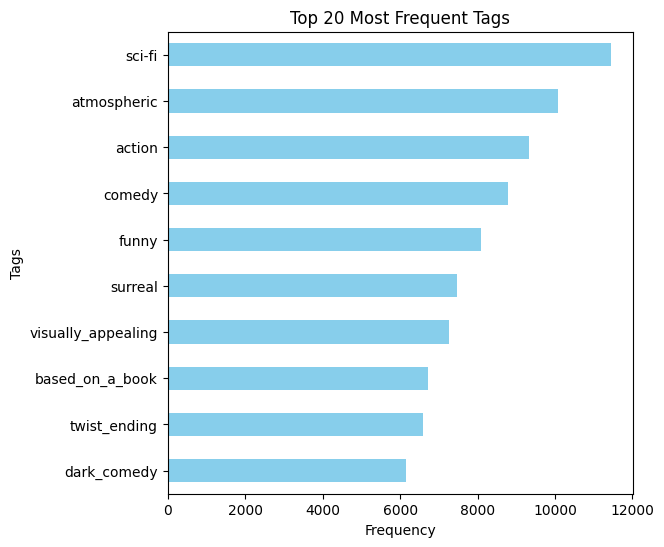

In [85]:
# Count the frequency of each tag and get the top 10
top_20_tags = tags['tag'].value_counts().head(10)

# Plotting
plt.figure(figsize=(6, 6))
top_20_tags.plot(kind='barh', color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Tags')
plt.title('Top 20 Most Frequent Tags')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent tags on top
plt.show()

We'll create a new DataFrame, `movie_tags`, with movie details and merge it with `tags_grouped` to include tags. We then combine tags and genres into a new column called `soup`, concatenating them into a single string for each movie, which will represent the movie's "content."

In [94]:
movie_tags = filtered_movies[['movieId', 'title', 'year', 'score', 'genres']].copy().reset_index(drop=True)
movie_tags = movie_tags.merge(tags_grouped, on='movieId', how='left')

# Combine tags with genre information for each movie to create a `soup` column.
movie_tags['tag'] = movie_tags['tag'].fillna('')
movie_tags['genres'] = movie_tags['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
movie_tags['soup'] = movie_tags['tag'] + ' ' + movie_tags['genres']
movie_tags.head(5)

,movieId,title,year,score,genres,tag,soup
0,318,"Shawshank Redemption, The",1994,4.401238,crime drama,morgan_freeman inspirational twist_ending thou...,morgan_freeman inspirational twist_ending thou...
1,159817,Planet Earth,2006,4.332311,documentary,nature stunning_photography amazing_photograph...,nature stunning_photography amazing_photograph...
2,858,"Godfather, The",1972,4.312134,crime drama,mafia classic great_acting organized_crime al_...,mafia classic great_acting organized_crime al_...
3,170705,Band of Brothers,2001,4.310914,action drama war,world_war_ii war not_a_movie drama military gr...,world_war_ii war not_a_movie drama military gr...
4,202439,Parasite,2019,4.284956,comedy drama,dark_comedy social_commentary intense twists_&...,dark_comedy social_commentary intense twists_&...


### TF-IDF

Note that our content consists of text with many different words. We need a way to identify which words or terms are more important and best represent the movie's content. To achieve this, we need a method to disregard common words and highlight more specific, meaningful terms.

**TF-IDF** (Term Frequency-Inverse Document Frequency) is a text analysis technique that measures the importance of a word in a document relative to a collection of documents (corpus). It combines:

- **Term Frequency (TF)**: How often a word appears in a specific document.
- **Inverse Document Frequency (IDF)**: How common or rare a word is across all documents.

The TF-IDF score highlights words that are frequent in a document but rare across the entire corpus, making it useful for identifying key terms 
and improving text relevance in various applications.


The TF-IDF score for a term \( t \) in a document \( d \) is calculated as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

where:

- **Term Frequency (TF)** is given by:

$$
\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}
$$

- **Inverse Document Frequency (IDF)** is given by:

$$
\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}\right)
$$


We can use `TfidfVectorizer` from `sklearn.feature_extraction.text` module to calculate the TF-IDF scores for each word in each movie.


In [48]:
# Convert the tag lists to a matrix using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(movie_tags['soup'])
X_tfidf

<1000x45320 sparse matrix of type '<class 'numpy.float64'>'
	with 171697 stored elements in Compressed Sparse Row format>

In some cases, it might be more useful to use raw counts rather than normalizing by document frequency. For example, a tag that occurs multiple times for a movie, even if it's also used in other movies, can still be significant. Therefore, analyzing the raw count of tags per movie can be insightful. To do this, we can use `CountVectorizer` to generate a matrix of term counts for each movie.

In [95]:
# Convert the tag lists to a matrix using CountVectorizer
count_vectorizer = CountVectorizer()
X_count = count_vectorizer.fit_transform(movie_tags['soup'])
X_count

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 171697 stored elements and shape (1000, 45320)>

We can create helper functions to display the top tags per movie based on either TF-IDF scores or raw tag counts.

In [50]:
def get_top_tags_for_movie(movie_title, vectorizer, tag_matrix, top=10):
    """
    Returns the top N tags for a given movie based on their count.

    Args:
        movie_title: The title of the movie.
        vectorizer: The fitted Vectorizer object.
        tag_matrix: The tag count matrix.
        top: The number of top tags to return.

    Returns:
        A list of tuples containing the top N tags and their counts or tfidf score.
    """
    # Get the movie ID for the given title
    movie_id = get_movie_id(movie_title)

    # Get the row index corresponding to the movie ID
    movie_index = movie_tags[movie_tags['movieId'] == movie_id].index[0]

    # Get the tag counts for the movie
    tag_counts = tag_matrix[movie_index].toarray().flatten()

    # Get the indices of the top N tags
    top_tag_indices = tag_counts.argsort()[::-1][:top]

    # Get the names of the top N tags
    top_tags = [(vectorizer.get_feature_names_out()[i], round(tag_counts[i], 4)) for i in top_tag_indices]

    return top_tags


In [51]:
# Top tags for a given movie based on TF-IDF scores
get_top_tags_for_movie('Fight Club', vectorizer=tfidf_vectorizer, tag_matrix = X_tfidf)

[('twist_ending', 0.3639),
 ('edward_norton', 0.3315),
 ('psychology', 0.322),
 ('brad_pitt', 0.3068),
 ('dark_comedy', 0.2623),
 ('philosophy', 0.2417),
 ('provoking', 0.2059),
 ('thought', 0.2048),
 ('social_commentary', 0.2034),
 ('surreal', 0.1826)]

In [52]:
# Top tags for a given movie based on raw tag counts
get_top_tags_for_movie('Fight Club', vectorizer=count_vectorizer, tag_matrix = X_count)

[('twist_ending', 347),
 ('psychology', 289),
 ('dark_comedy', 269),
 ('social_commentary', 227),
 ('thought', 217),
 ('provoking', 217),
 ('philosophy', 210),
 ('edward_norton', 203),
 ('surreal', 196),
 ('brad_pitt', 193)]

### Content Embedding
Finally, we are prepared to train our content-based model. The content-based model will embed each movie's content into a multi-dimensional space, where each term represents a dimension and the TF-IDF or count value represents the value in that dimension.

To measure similarity between items in this high-dimensional space, we commonly use cosine similarity, which calculates the cosine of the angle between two vectors.

We can use the `cosine_similarity` function from `sklearn.metrics.pairwise` to generate the similarity matrix between movies based on their high-dimensional representations.

In [53]:
# Calculate cosine similarity between all movies
similarity_matrix = cosine_similarity(X_count)
similarity_matrix.shape

(1000, 1000)

### Content-based recommendations
Now, for any given movie, we can find similar movies by identifying the closest ones in the high-dimensional space. Our `content_based_recommendations` function will return the most similar movies for this purpose.

In [54]:
def content_based_recommendations(movie_title, similarity_matrix=similarity_matrix, movie_tags=movie_tags, top=5):
    """
    Provides content-based movie recommendations.

    Args:
        movie_title: The title of the movie to get recommendations for.
        similarity_matrix: The cosine similarity matrix.
        movies: The DataFrame containing movie information.
        top: The number of recommendations to return.

    Returns:
        A DataFrame with the recommended movies.
    """
    # Get the index of the movie
    movie_index = movie_tags[movie_tags['title'].str.lower() == movie_title.lower()].index[0]

    # Get similarity scores for all movies compared to the given movie
    similarity_scores = similarity_matrix[movie_index]
    high_similarity_indices = np.argsort(similarity_scores)[-(top+1):][::-1]
    high_similarity_scores = similarity_scores[high_similarity_indices].round(4)

    # Sort movies by similarity score in descending order
    top_similar_movies = movie_tags.iloc[high_similarity_indices][['movieId','title','year','score','genres','tag']].copy()

    similarity_col = f'similarity_with_{movie_title}'
    top_similar_movies[similarity_col] = high_similarity_scores

    # Return the top N recommended movies
    return top_similar_movies


For example, we used the model to recommend movies similar to *Fight Club*. The similarity score of *Fight Club* with itself is 1, indicating the highest possible level of similarity.

By examining the top recommended movies, we can confirm that the model effectively identified similarities through overlapping genres and tags. This demonstrates how the model leverages content attributes to find and suggest similar movies.

In [55]:
content_based_recommendations('Fight Club')

,movieId,title,year,score,genres,tag,similarity_with_Fight Club
9,2959,Fight Club,1999,4.224854,action crime drama thriller,twist_ending psychology dark_comedy social_com...,1.0000
219,4878,Donnie Darko,2001,3.929046,drama mystery sci-fi thriller,surreal time_travel thought-provoking psycholo...,0.5945
672,628,Primal Fear,1996,3.754089,crime drama mystery thriller,twist_ending edward_norton psychology courtroo...,0.5604
221,2997,Being John Malkovich,1999,3.927537,comedy drama fantasy,surreal dark_comedy surrealism mindfuck though...,0.5301
551,8950,The Machinist,2004,3.794589,drama mystery thriller,twist_ending psychology christian_bale schizop...,0.5013
53,47,Seven (a.k.a. Se7en),1995,4.082960,mystery thriller,twist_ending serial_killer psychology morgan_f...,0.4726


## RAG (Retrieval-Augmented Generation)

**Retrieval Augmented Generation (RAG)** is an advanced technique that enhances a Generative AI application's accuracy by retrieving and incorporating relevant, real-time data from a database into the large language model's (LLM) responses. By integrating retrieval with generation, RAG enhances the ability to generate responses that are both factually accurate and contextually appropriate

RAG addresses several limitations of traditional LLMs:
1. **Recency**: LLMs, like ChatGPT, have static knowledge that quickly becomes outdated. RAG allows these models to access the most current information, mitigating issues like "hallucinations" (incorrect or outdated answers).
2. **Domain-Specific Knowledge**: RAG provides context-specific data that LLMs might not inherently possess, improving accuracy for specialized queries.
3. **Transparency**: By enabling citation of sources, RAG improves auditability and transparency of the model’s outputs.

**Why Use RAG?**
- **Cost-Efficiency**: Building or fine-tuning large models is expensive and complex. RAG is a more cost-effective approach, leveraging existing models and adding dynamic data retrieval.
- **Flexibility**: It offers better adaptability than prompt engineering or fine-tuning, as it dynamically integrates up-to-date information and context-specific data.

RAG effectively bridges the gap between static LLM capabilities and the need for current, domain-specific information, making it a preferred method for enhancing AI applications.

**RAG for movie recommendation**
To implement a RAG/LLM-based recommender system, we first embed and store movie descriptions in a vector database. Next, we use LangChain's retrieval-based QA to query the vector store with a given query. Finally, we leverage a large language model, using the retrieved results from the vector store as context, to generate recommendations.

### Vector database
A vector database stores and manages high-dimensional vectors, which are numerical representations of data points, such as embeddings from machine learning models. It allows for efficient similarity searches and retrieval of relevant items based on vector similarity.

There are a variety of vector databases that we can choose from:

- **Pinecone**: Known for its scalability and ease of use in managing high-dimensional vector data.
- **Milvus**: Popular for its open-source nature and high performance in similarity search and large-scale vector management.
- **Elasticsearch**: Widely used for full-text search and now supports vector search with its k-Nearest Neighbors (k-NN) plugin.
- **Weaviate**: Offers semantic search capabilities and real-time vector search, integrating well with machine learning models.
- **FAISS (Facebook AI Similarity Search)**: Frequently used for efficient similarity search and clustering in high-dimensional spaces, often integrated into custom solutions.


**Pinecone** was chosen for this project because it provides scalable and high-performance vector search capabilities, making it ideal for managing and querying large-scale vector embeddings efficiently. Pinecone's ability to handle high-dimensional data and perform real-time searches supports robust and responsive recommendation systems.

### Configuring API Keys

For this project, we'll use Pinecone, OpenAI GPT models, and LangChain. Since these are paid services, we will need to obtain API keys.

To securely manage API keys for accessing various services, we'll load environment variables from a `.env` file using Python's `dotenv` library.  
- PINECONE_API_KEY: This key is used to access Pinecone vector database

- OPENAI_API_KEY: This key is used to interact with OpenAI’s API, which can include accessing language models like GPT.

- LANGCHAIN_API_KEY: This key is used to access LangChain services, which typically involve tools and APIs for building applications that leverage language models and other AI capabilities.


In [ ]:
# Loading API keys
load_dotenv()

PINECONE_API_KEY = os.getenv('PINECONE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')

### Movie descriptions

In order to have more context on the movies, we’ll enhance our dataset by adding movie overviews from another dataset, matching movie titles using imdb_id. Here is a link to the dataset for movie overviews on Kaggle: [Movie Recommender Systems](https://www.kaggle.com/code/rounakbanik/movie-recommender-systems).

In [101]:
movies_metadata = pd.read_csv('movies_metadata.csv')
movies_metadata['imdbId'] = movies_metadata['imdb_id'].str.replace('tt', '').fillna(-1).astype(int)

<ipython-input-101-6504b1833af7>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv('movies_metadata.csv')


In [ ]:
movie_desc = movie_tags.merge(links[['movieId', 'imdbId']], on='movieId', how='left')
movie_desc = movie_desc.merge(movies_metadata[['imdbId', 'overview']], on='imdbId', how='left')
movie_desc.head(3)

,movieId,title,year,score,genres,tag,soup,imdbId,overview
0,318,"Shawshank Redemption, The",1994,4.401238,crime drama,morgan_freeman inspirational twist_ending thou...,morgan_freeman inspirational twist_ending thou...,111161,Framed in the 1940s for the double murder of h...
1,159817,Planet Earth,2006,4.332311,documentary,nature stunning_photography amazing_photograph...,nature stunning_photography amazing_photograph...,795176,A documentary miniseries described by its make...
2,858,"Godfather, The",1972,4.312134,crime drama,mafia classic great_acting organized_crime al_...,mafia classic great_acting organized_crime al_...,68646,"Spanning the years 1945 to 1955, a chronicle o..."


In [ ]:
# Save the dataset
movie_desc.to_csv('movie_desc.csv', index=False)

### Tokens

When working with language models, managing token count is crucial because LLMs process text in token units. **Tiktoken** is a library that efficiently handles tokenization and counting.

We can use the **Tiktoken** library to measure the number of tokens in any text, which is especially important for handling large documents and chunking them based on token count.

Each language model may have its own encoding scheme. For example, `gpt-4o-mini` model that we use in this project uses the `o200k_base` encoding. We need to specify this encoding in **Tiktoken** to obtain an accurate token count.

In [328]:
# Counting tokens

llm_model_name = 'gpt-4o-mini-2024-07-18'
tiktoken_encoding = tiktoken.encoding_for_model(llm_model_name)
tokenizer = tiktoken.get_encoding(tiktoken_encoding.name)

# Create the length function
def tiktoken_len(text):
    tokens = tokenizer.encode(text, disallowed_special=())
    return len(tokens)

print(f'tiktoken_encoding for {llm_model_name}: {tiktoken_encoding.name}')

sample_text = "find the length of this text in tokens"
print(f'number of tokens in "{sample_text}": {tiktoken_len(sample_text)}')

tiktoken_encoding for gpt-4o-mini-2024-07-18: o200k_base
number of tokens in "find the length of this text in tokens": 8


### Vector embeddings
Embeddings are high-dimensional numerical representations of content data (in this case, text description of the movies). These vectors, stored in a vector database, capture semantic meaning and allow models to process and compare text more effectively.

Here, we'll use `text-embedding-ada-002` embedding model from OpenAI that generates embeddings for text. The embedding dimension refers to the size of the vectors produced by the model. For instance, this model generates 1536-dimensional vectors.

In [214]:
# Initialize embeddings
embedding_model_name = 'text-embedding-ada-002'
embedding_dim = 1536

embeddings = OpenAIEmbeddings(model=embedding_model_name, openai_api_key=OPENAI_API_KEY)

As an example, we can embedd two chunks of text using our chosen embedding model.

In [215]:
# Embedding sample texts
test_embeddings = embeddings.embed_documents(['first chunk of text', 'second chunk of text'])
print(f'result shape: {len(test_embeddings)} x {len(test_embeddings[0])}')

result shape: 2 x 1536


### Pinecone
As mentioned earlier, we need to store our embedded data in a vector database optimized for efficiently finding similar vectors. This allows for fast and scalable similarity searches, crucial for retrieving related movie descriptions based on their embeddings.

First, we need to configure our Pinecone clinet with our API key.

In [211]:
# Configure client
pc = Pinecone(api_key=PINECONE_API_KEY)
spec = ServerlessSpec(cloud="aws", region="us-east-1")


A **Pinecone index** is a data structure used to store and manage high-dimensional vectors in Pinecone's vector database. It facilitates efficient similarity searches by organizing and indexing vectors, allowing for fast retrieval of similar items based on their vector representations.

We can retrieve a list of our existing indexes to ensure we don't overwrite a previous index. (This should return an empty list the first time)

In [212]:
# Existing index
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]
existing_indexes

['movie-rag']

Now we can create our index if it does not already exist using the following steps:

In [144]:
# Create Pinecone index
index_name = 'movie-rag'

# Check if index already exists (it shouldn't if this is first time)
if index_name not in existing_indexes:
    # If does not exist, create index
    pc.create_index(
        index_name,
        dimension=embedding_dim,
        metric='cosine',
        spec=spec
    )
    # Wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)

# Connect to index
index = pc.Index(index_name)
time.sleep(1)

# View index stats to verify our index is empty
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

Let's create the `text` field for each movie by concatenating the movie overview, genres, and top 20 tags.

In [200]:
# Combine movie overvie, genres, and top 20 tags to create movie text for embedding
movie_desc['text'] = (movie_desc['overview'].fillna('') + ' ' +
                      movie_desc['genres'] + ' ' +
                      movie_desc['tag'].apply(lambda x: ' '.join(x.split()[:20])))
movie_desc.head(3)


,movieId,title,year,score,genres,tag,soup,imdbId,overview,text
0,318,"Shawshank Redemption, The",1994,4.401238,crime drama,morgan_freeman inspirational twist_ending thou...,morgan_freeman inspirational twist_ending thou...,111161,Framed in the 1940s for the double murder of h...,Framed in the 1940s for the double murder of h...
1,159817,Planet Earth,2006,4.332311,documentary,nature stunning_photography amazing_photograph...,nature stunning_photography amazing_photograph...,795176,A documentary miniseries described by its make...,A documentary miniseries described by its make...
2,858,"Godfather, The",1972,4.312134,crime drama,mafia classic great_acting organized_crime al_...,mafia classic great_acting organized_crime al_...,68646,"Spanning the years 1945 to 1955, a chronicle o...","Spanning the years 1945 to 1955, a chronicle o..."


### Create vector database

**Upserting** is combination of "update" and "insert". It involves adding new records to a database and updating existing ones if they already exist. This ensures that the database remains current with the latest data.

**Metadata** is used to store additional information about each record, such as movie titles, release year, or any other relevant attributes. This helps in efficiently retrieving and understanding the context of the data.

**Creating batches** involves grouping data into smaller chunks for processing. This approach is used to handle large volumes of data more efficiently, reducing memory usage and speeding up operations like upserting embeddings into the vector database.



In [ ]:
# Creating vector database using movie info

total_items = len(movie_desc)
batch_limit = 100  # batch size for inserting vectors in Pinecone
texts, metadatas = [], []

for i, item in tqdm(movie_desc.iterrows(), desc='creating vector database', total=total_items):
    # create metadata fields for each item
    metadata = {
        'movieId': str(item['movieId']),
        'title': item['title'],
        'year': str(item['year']),
        'text': item['text']
    }

    # Append to current batches
    texts.append(item['text'])
    metadatas.append(metadata)

    # Insert batches if reached the batch_limit or last ite
    if len(texts) >= batch_limit or i == total_items - 1:
        ids = [str(uuid4()) for _ in range(len(texts))]
        embeds = embeddings.embed_documents(texts)  # embedding each chunk of text
        index.upsert(vectors=zip(ids, embeds, metadatas))
        texts = []
        metadatas = []


In [201]:
# Verify our data is inserted into the vector database
index.describe_index_stats()

{'dimension': 1536,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 1000}},
 'total_vector_count': 1000}

### Query vector database

Now that we've inserted our information into the database, we can query it using any given text. First, we need to create our vectorstore object (here we'll use `Pinecone` from `langchain.vectorstores`), and then we can pass a text query to retrieve the top-k similar items from the vector store.

In [266]:
# Initialize the vector store object
text_field = "text"  # the metadata field that contains our text
vectorstore = Pinecone(index, embeddings, text_field)

In [280]:
# Similairty search in the Vector database
query = "sci-fi movies about space exploration?"
results = vectorstore.similarity_search(query, k=3)
for item in results:
    print(item.metadata)
    print(item.page_content)
    print()

{'movieId': '109487', 'title': 'Interstellar', 'year': '2014'}
Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. sci-fi imax space thought-provoking sci-fi time_travel christopher_nolan good_science physics relativity artificial_intelligence visually_appealing philosophical_issues space_travel time-travel hans_zimmer matthew_mcconaughey wormhole space_exploration black_hole epic science_fiction

{'movieId': '68358', 'title': 'Star Trek', 'year': '2009'}
The fate of the galaxy rests in the hands of bitter rivals. One, James Kirk, is a delinquent, thrill-seeking Iowa farm boy. The other, Spock, a Vulcan, was raised in a logic-based society that rejects all emotion. As fiery instinct clashes with calm reason, their unlikely but powerful partnership is the only thing capable of leading their crew through unimaginable da

### RAG-based recommendations

**RetrievalQA** is a process that combines retrieval and question-answering. It involves retrieving relevant documents or data from a database based on a query and then using a question-answering model to generate a specific answer from the retrieved information. This approach enhances the accuracy and relevance of responses by leveraging contextual information from the retrieved data.

Here, **RetrievalQA** class in LangChain uses our vector store as the retriever. It passes the query to the vector store, retrieves relevant results, and then uses these results as context for the large language model (LLM) to generate "context-aware" answers.


In [281]:
# Completion LLM
llm = ChatOpenAI(
    openai_api_key=OPENAI_API_KEY,
    model_name=llm_model_name,
    temperature=0.0,
)

# RetrievalQA chain
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectorstore.as_retriever(),
    return_source_documents=True,
)

In [305]:
# Invoke RetrievalQA chain
query = "recommend three sci-fi movies about space exploration"
results = qa.invoke(query)

In [307]:
# Query and the results
print('query: ' + results['query']+'\n')
print('result:\n' + results['result'])

query: recommend three sci-fi movies about space exploration

result:
Here are three sci-fi movies about space exploration:

1. **Interstellar** - This film follows a group of explorers who use a newly discovered wormhole to travel beyond the limitations of human space travel in search of a new home for humanity.

2. **Arrival** - After alien crafts land around the world, a linguist is recruited by the military to communicate with the extraterrestrial beings and determine their intentions, exploring themes of language and understanding.

3. **Star Trek** - This reboot of the classic franchise features the adventures of James Kirk and Spock as they navigate the challenges of space exploration and the conflicts that arise from their differing approaches to problem-solving.


### Validating context

We can inspect the context provided by the vector store by setting `return_source_documents=True` for the RetrievalQA object. This will allow you to validate the retrieved documents used to generate the answers.

In [308]:
# Validate provided context to the LLM
print('Sources:')
for doc in results['source_documents']:
    print(doc.metadata)
    print(doc.page_content)
    print()

Sources:
{'movieId': '109487', 'title': 'Interstellar', 'year': '2014'}
Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. sci-fi imax space thought-provoking sci-fi time_travel christopher_nolan good_science physics relativity artificial_intelligence visually_appealing philosophical_issues space_travel time-travel hans_zimmer matthew_mcconaughey wormhole space_exploration black_hole epic science_fiction

{'movieId': '3471', 'title': 'Close Encounters of the Third Kind', 'year': '1977'}
After an encounter with UFOs, a line worker feels undeniably drawn to an isolated area in the wilderness where something spectacular is about to happen. adventure drama sci-fi aliens sci-fi steven_spielberg first_contact space extraterrestrial_life visually_appealing music alien ufo abduction classic ufos military parapsychology oscar

### Manual Vectorstore-LLM chain implementation
Alternatively, we can manually query the vector database to retrieve and potentially process the context, then pass this context to our LLM. This approach offers greater flexibility, allowing us to set a system message for the LLM and combine context from multiple sources or vector stores.

In [316]:
# Parser is used to parse LLM outputs
parser = StrOutputParser()

# Define a prompt template for sentiment analysis
recom_prompt  = ChatPromptTemplate.from_messages([
    ("system", "You are a movie critic aiming to assist people in selecting films"),  # System message to set context
    ("human", "{query}\n\nContext:\n{context}")
])

# Create the recommendation chain
recom_chain = recom_prompt | llm | parser

# Invoke chain
query = "recommend three sci-fi movies about space exploration"
context = vectorstore.similarity_search(query, k=4)

results = recom_chain.invoke({'query':query, 'context':context})

Here are three excellent sci-fi movies that delve into the theme of space exploration:

1. **Interstellar (2014)** - Directed by Christopher Nolan, this film follows a group of explorers who utilize a newly discovered wormhole to transcend the limitations of human space travel. It combines stunning visuals with thought-provoking themes about time, relativity, and the survival of humanity. The film features a strong performance by Matthew McConaughey and a haunting score by Hans Zimmer.

2. **Arrival (2016)** - In this cerebral sci-fi film directed by Denis Villeneuve, an expert linguist, played by Amy Adams, is recruited by the military to communicate with alien visitors who have landed on Earth. The film explores themes of language, time, and human connection, offering a unique take on first contact with extraterrestrial life. Its beautiful visuals and intricate storytelling make it a standout in the genre.

3. **Close Encounters of the Third Kind (1977)** - A classic from Steven Spie

In [322]:
# Query and the results
print(f'query: {query}\n')
print(f'results:\n{results}')

query: recommend three sci-fi movies about space exploration

results:
Here are three excellent sci-fi movies that delve into the theme of space exploration:

1. **Interstellar (2014)** - Directed by Christopher Nolan, this film follows a group of explorers who utilize a newly discovered wormhole to transcend the limitations of human space travel. It combines stunning visuals with thought-provoking themes about time, relativity, and the survival of humanity. The film features a strong performance by Matthew McConaughey and a haunting score by Hans Zimmer.

2. **Arrival (2016)** - In this cerebral sci-fi film directed by Denis Villeneuve, an expert linguist, played by Amy Adams, is recruited by the military to communicate with alien visitors who have landed on Earth. The film explores themes of language, time, and human connection, offering a unique take on first contact with extraterrestrial life. Its beautiful visuals and intricate storytelling make it a standout in the genre.

3. **C

In [325]:
# Validate the retrieved context
print(f'Retrieved context:')
for doc in context:
    print(doc.metadata)
    print(doc.page_content)
    print()

Retrieved context:
{'movieId': '109487', 'title': 'Interstellar', 'year': '2014'}
Interstellar chronicles the adventures of a group of explorers who make use of a newly discovered wormhole to surpass the limitations on human space travel and conquer the vast distances involved in an interstellar voyage. sci-fi imax space thought-provoking sci-fi time_travel christopher_nolan good_science physics relativity artificial_intelligence visually_appealing philosophical_issues space_travel time-travel hans_zimmer matthew_mcconaughey wormhole space_exploration black_hole epic science_fiction

{'movieId': '3471', 'title': 'Close Encounters of the Third Kind', 'year': '1977'}
After an encounter with UFOs, a line worker feels undeniably drawn to an isolated area in the wilderness where something spectacular is about to happen. adventure drama sci-fi aliens sci-fi steven_spielberg first_contact space extraterrestrial_life visually_appealing music alien ufo abduction classic ufos military parapsycho

### Deleting the vector database
Finally, we can delete the vector database if it is no longer needed.

In [326]:
# Deleting the vector database index
pc.delete_index(index_name)